In [1]:
# Imports (numpy, pandas, matplotlib, seaborn imported autom)
import requests
from etherscan import Etherscan
from BondingCurveNexus import config

In [2]:
# activate etherscan client
eth_client = Etherscan(config.etherscan_api)

In [3]:
eth_client.get_eth_last_price()

{'ethbtc': '0.07375',
 'ethbtc_timestamp': '1651224118',
 'ethusd': '2893.12',
 'ethusd_timestamp': '1651224124'}

# Nexus Tokenomics Investigation

## Current Bonding Curve Set-up & Parameters

In [19]:
nxm_supply = 6_883_752
act_cover = 138_581
capital_factor = 4.8
mcr_floor = 162_425
mcr = max(mcr_floor, act_cover/capital_factor)
cap_pool = 155_445
mcrp = cap_pool/mcr
book_value = cap_pool/nxm_supply
print(f'mcrp: {mcrp}, book value: {book_value}')

mcrp: 0.9570263198399261, book value: 0.02258143524054905


In [11]:
a = 0.01028
c = 5_800_000
token_price = a + (mcr/c)*(mcrp**4)
token_price

0.03377202254539437

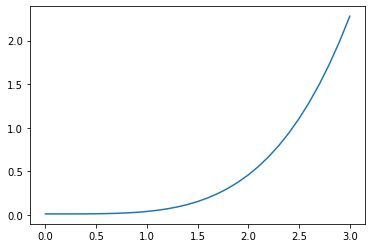

In [20]:
perc_range = np.linspace(0, 3, 31)

token_price_range = a + (mcr/c)*(perc_range**4)
plt.plot(perc_range, token_price_range);

## New Version - Capital Entry

### Current wNXM price feed

In [8]:
url = 'https://api.coingecko.com/api/v3/simple/price'
params = {
        'ids':'wrapped-nxm',
        'vs_currencies': 'eth'
        }
current_wnxm_price_eth = requests.get(url, params=params).json()['wrapped-nxm']['eth']
current_wnxm_price_eth

0.00979169

### Bond Discount Formula

What are the discounts we want? Initial attempt:
 - **12.5%** per annum for time delay at 95%
 - Extra 5% at 90% MCR
 - Extra 15% at 80% MCR
 - Extra 30% at 70% MCR
 - Below grows at same rate
 
 Maybe this is something we can discuss with community

In [17]:
115*0.125

14.375

In [49]:
perc_range_below_100 = np.linspace(0, 1, 21)
perc_range_below_100

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

Aiming for:

f(0.9) = 0.05

f(0.8) = 0.15

f(0.7) = 0.3

Seems like (1-MCR%)^1.3 is a reasonable approximation

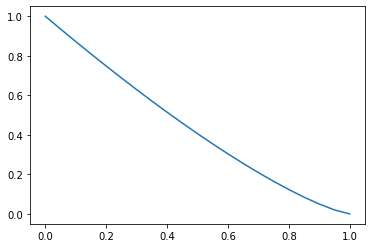

In [78]:
# creating shape of discount vs. mcr_perc below 100%
def mcr_perc_bond_discount(mcr_perc):
    return (1 - mcr_perc)**1.3

mcr_discount_range = mcr_perc_bond_discount(perc_range_below_100)

plt.plot(perc_range_below_100, mcr_discount_range);

In [80]:
{'0.0': mcr_perc_bond_discount(0.0),
'0.1': mcr_perc_bond_discount(0.1),
'0.2': mcr_perc_bond_discount(0.2),
'0.3': mcr_perc_bond_discount(0.3),
'0.4': mcr_perc_bond_discount(0.4),
'0.5': mcr_perc_bond_discount(0.5),
'0.6': mcr_perc_bond_discount(0.6),
'0.7': mcr_perc_bond_discount(0.7),
'0.8': mcr_perc_bond_discount(0.8),
'0.9': mcr_perc_bond_discount(0.9),
 '1': mcr_perc_bond_discount(1)
}

{'0.0': 1.0,
 '0.1': 0.871997545077537,
 '0.2': 0.7481987582580971,
 '0.3': 0.6289664092534478,
 '0.4': 0.514750320266457,
 '0.5': 0.40612619817811774,
 '0.6': 0.30386311717294956,
 '0.7': 0.2090535905807847,
 '0.8': 0.12340677254400188,
 '0.9': 0.050118723362727206,
 '1': 0.0}

In [74]:
time_arb_discount = 0.15


def bond_discount(days, mcr_perc):
    # Instantaneous - you can buy NXM at the wNXM market price
    # Linearly 365 days to provide 15% discount (equivalent to APY of 15%)
    return 0.15*min(1, days/365) + (1 - min(1, mcr_perc))**1.3

In [75]:
bond_discount(365, mcr_perc)

0.16723806362857296

## New Version - Capital Exit

### Weighted average days on covers 

In [35]:
### TODO: Provide live feed instead of just pulling in .csv
# https://github.com/rchen8/nexus-mutual-tracker

In [29]:
active_covers_expiration = pd.read_csv('../raw_data/active_cover_amount_by_expiration_date.csv')

In [30]:
active_covers_expiration.columns = ['exp_time', 'USD', 'ETH']

In [31]:
active_covers_expiration['exp_time'] = pd.to_datetime(active_covers_expiration['exp_time'])

In [32]:
active_covers_expiration.dtypes

exp_time    datetime64[ns]
USD                float64
ETH                float64
dtype: object

In [33]:
active_covers_expiration['days_remaining'] = active_covers_expiration['exp_time']-pd.Timestamp.now().normalize()

In [34]:
active_covers_expiration['minutes_remaining'] = active_covers_expiration['days_remaining']/np.timedelta64(1, 'm')

In [35]:
wavg_minutes = ((active_covers_expiration['ETH']*active_covers_expiration['minutes_remaining'])
                /active_covers_expiration['ETH'].sum()).sum()
wavg_minutes

84635.90804891243

In [37]:
# this needs an amplification factor
wavg_days = wavg_minutes/(24*60)
wavg_days

58.77493614507808

### Calculating Exit Penalty

In [29]:
def exit_penalty(days_selected):
    if mcr_perc > 100:
        return 1
    else:
        return min(1, days_selected/wavg_days)

In [30]:
exit_penalty(30)

0.5210343496719414

## Initial Reverse Dutch Auction Mechanism

At launch, exit price = wnxm price

Price slowly increases, but starts dropping down once people try to exit through the mechanism

Keeps going up, stops at book value.

Incentive not to wait longer - some people may end up exiting in front of you and drive down the price.
What if you believe it'll go up eventually anyway...

## Scenario testing

1. WNXM price movements & how the market reacts
2. Crowd exits quickly/slowly/doesn't want to exit at all
    - 5/10/20/50/80% instant withdrawals?